<a href="https://colab.research.google.com/github/SavchukDI/3d_ml_mai/blob/main/3dml_lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Установка необходимых для работы библиотек

In [1]:
!pip install torch torchvision
!pip install trimesh
!pip install git+https://github.com/facebookresearch/pytorch3d.git@v0.2.0
!pip install celluloid
!pip install tqdm

     |████████████████████████████████| 639 kB 12.9 MB/s 
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision v0.2.0) to /tmp/pip-req-build-fs908l_h
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-fs908l_h
  Running command git checkout -q 686c8666d31d932ed42d3cd7319f249fc75e89a9
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 28.6 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.2.0-cp37-cp37m-linux_x86_64.whl size=13983354 sha256=838764322849180d71f8c711be3e59877a7a45366dc90006215504bb6229ae1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-hine7y14/wheels/8c/91/50/2ffecd5349664ff8651ba4ee495451889cfe7690af362ce53c
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=d27fa1f37e499aef369b722aedc550f89a95da207db975deed4386b11b50a257
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719

#Загрузка библиотек

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# You should work in Jupyter.
from tqdm import tqdm_notebook

from celluloid import Camera

import torch

# untilitis 
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes, Textures

# render 
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader
)

import trimesh
from trimesh import registration
from trimesh import visual

#Выбор GPU или CPU

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

#Загрузка полигональной модели

In [4]:
!mkdir data

In [5]:
!wget -nc -P ./data/ 'https://docs.google.com/uc?export=download&id=1iEQnNB1njpoWwk6xPWdYm7ISMJ-iHfij' -O 'Chair.obj'
!mv ./Chair.obj ./data/

--2021-12-10 23:25:13--  https://docs.google.com/uc?export=download&id=1iEQnNB1njpoWwk6xPWdYm7ISMJ-iHfij
Resolving docs.google.com (docs.google.com)... 173.194.76.102, 173.194.76.101, 173.194.76.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.76.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-98-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9mtc8k7rqocdf7823g3sd1o8pe403i2a/1639178700000/07264610302122334822/*/1iEQnNB1njpoWwk6xPWdYm7ISMJ-iHfij?e=download [following]
--2021-12-10 23:25:14--  https://doc-10-98-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9mtc8k7rqocdf7823g3sd1o8pe403i2a/1639178700000/07264610302122334822/*/1iEQnNB1njpoWwk6xPWdYm7ISMJ-iHfij?e=download
Resolving doc-10-98-docs.googleusercontent.com (doc-10-98-docs.googleusercontent.com)... 142.250.110.132, 2a00:1450:400c:c0d::84
Connecting to doc-10-98-docs.googleusercontent.com (doc-10-98-

In [28]:
path_to_model = os.path.join("data", "Chair.obj")

#Подготовка моделей

In [13]:
# Chair mesh in pytorch3d
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the chair.
Chair_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")
/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:486: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [80]:
# Trimesh sphere .obj model
#trimesh_sphere = trimesh.primitives.Sphere(subdivisions= 4)

# Sphere mesh in pytorch3d
sphere_mesh = ico_sphere(0, device)

verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]

# Rainbow sphere in pytorch3d
# verts_rgb = torch.rand_like(sphere_mesh.verts_list()[0])[None]

sphere_mesh.textures = Textures(verts_rgb=verts_rgb.to(device))

In [81]:
# Mesh to pointcloud with normals in pytorch3d
num_points_to_sample = 25000

Chair_vert, Chair_norm = sample_points_from_meshes(
    Chair_mesh,
    num_points_to_sample ,
    return_normals=True
)

sphere_vert, sphere_norm = sample_points_from_meshes(
    sphere_mesh,
    num_points_to_sample,
    return_normals=True
)

In [82]:
def convert_to_mesh(mesh):
    """Trimesh может загружать сцены вместо монолитного объекта
    """
    if isinstance(mesh, trimesh.Scene):
        return mesh.dump(concatenate=True)
    else:
        return mesh
    
def scale_to_unit(mesh: trimesh.Trimesh):
    length, weight, height = mesh.extents
    scale = 1 / max(length, weight, height)
    mesh.apply_scale((scale, scale, scale))

#Подготовка рендеринга полигональных моделей

In [83]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

# We can add a directional light in the scene. 
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

In [84]:
# Render the chair providing the values of R and T. 
image_Chair = phong_renderer(meshes_world=Chair_mesh, R=R, T=T)
image_sphere = phong_renderer(meshes_world=sphere_mesh, R=R, T=T)

image_sphere = image_sphere.cpu().numpy()
image_Chair = image_Chair.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


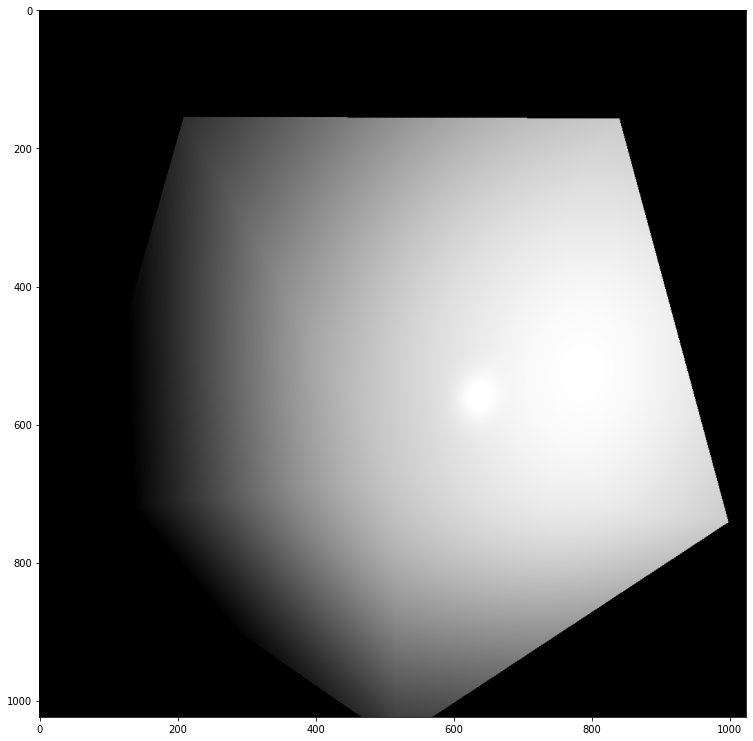

In [85]:
# Source mesh of sphere
plt.figure(figsize=(13, 13))
plt.imshow(image_sphere.squeeze())
plt.grid(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


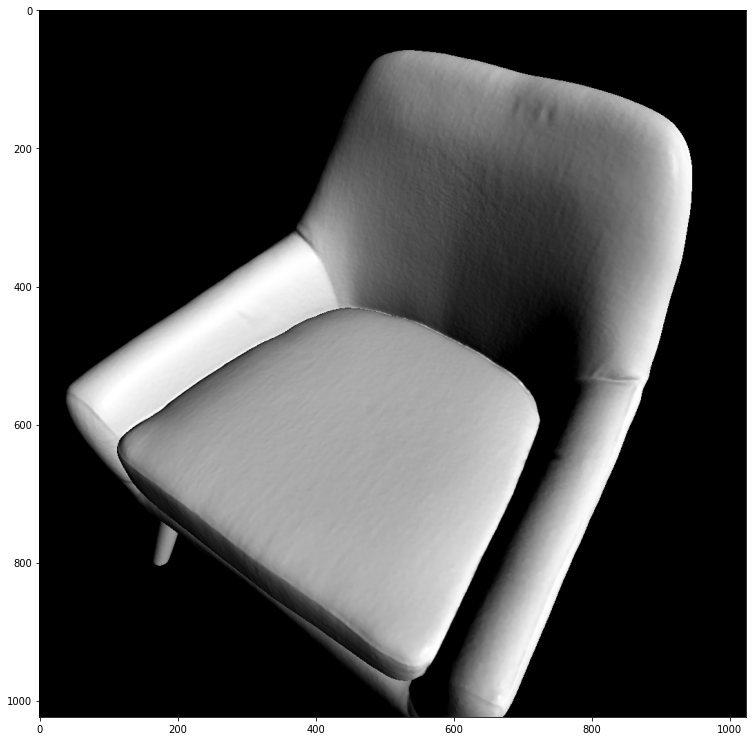

In [86]:
# Target mesh of chair
plt.figure(figsize=(13, 13))
plt.imshow(image_Chair.squeeze())
plt.grid(False)

#Вычисление метрик и регуляризаторов
Вычисление метрик chamfer loss и normal loss.

In [87]:
# Chamfer loss and normal loss
loss_chamfer, loss_normals_chamfer = chamfer_distance(
    Chair_vert, 
    sphere_vert, 
    x_normals=Chair_norm,
    y_normals=sphere_norm
)

In [88]:
print("Chamfer loss =", loss_chamfer.item())
print("Normal loss =", loss_normals_chamfer.item())

Chamfer loss = 0.1251647025346756
Normal loss = 0.7084259390830994


#Деформации сферы в кролика

Задаем оптимизируемые параметры и сам оптимизатор.

In [91]:
deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

Устанавливаем параметры для процесса оптимизации.

In [92]:
# Number of optimization steps
Niter = 1001
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 50

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

In [94]:
loop = tqdm_notebook(range(Niter))

%matplotlib inline
fig = plt.figure()
camera = Camera(fig)


for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = sphere_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(Chair_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    

    # Plot mesh
    if i % plot_period == 0 or i==0:

        # Render the chair providing the values of R and T. 
        image_Chair = phong_renderer(meshes_world=new_src_mesh, R=R, T=T)
        image_Chair = image_Chair.detach().cpu().numpy()

        plt.imshow(image_Chair.squeeze())
        plt.grid(False)
        camera.snap()

        
    # Optimization step
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/1001 [00:00<?, ?it/s]

IndexError: ignored

<Figure size 432x288 with 0 Axes>

In [95]:
animation = camera.animate()
animation.save('deformation_animation.mp4')

Text(0.5, 1.0, 'Loss vs iterations')

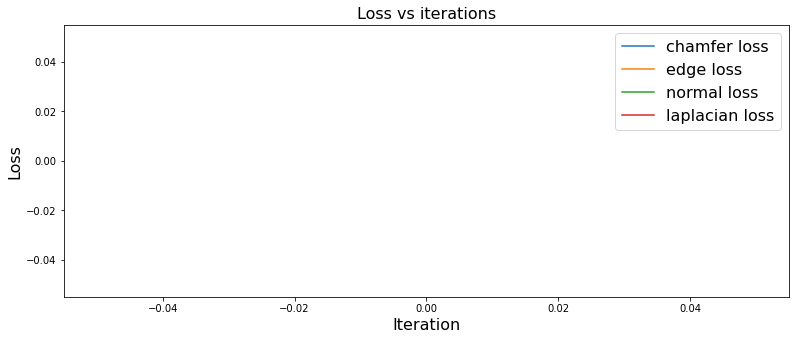

In [96]:
# Losses evaluation
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")